# 1. 加载并描述分析数据

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

# 设置 Matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimSong']
plt.rcParams['axes.unicode_minus'] = False

# 加载处理好的数据
df = pd.read_parquet('../Data/cleaned_full_data.parquet')
display(df)

,面积(㎡),总价(万),单价(元/㎡),地区,类型,租金(元/月),租金单价(元/㎡/月)
0,275.10,450.0,16357.0,Zhongxin,esf,NaN,NaN
1,87.00,60.0,6896.0,Zhongxin,esf,NaN,NaN
2,247.00,557.0,22550.0,Zhongxin,esf,NaN,NaN
3,80.00,115.0,14375.0,Zhongxin,esf,NaN,NaN
4,132.64,370.0,27895.0,Zhongxin,esf,NaN,NaN
...,...,...,...,...,...,...,...
8976,84.00,NaN,NaN,Zhongxin,zu,2400.0,28.571429
8977,113.00,NaN,NaN,Zhongxin,zu,2800.0,24.778761
8978,125.00,NaN,NaN,Zhongxin,zu,3200.0,25.600000
8979,95.00,NaN,NaN,Zhongxin,zu,1600.0,16.842105


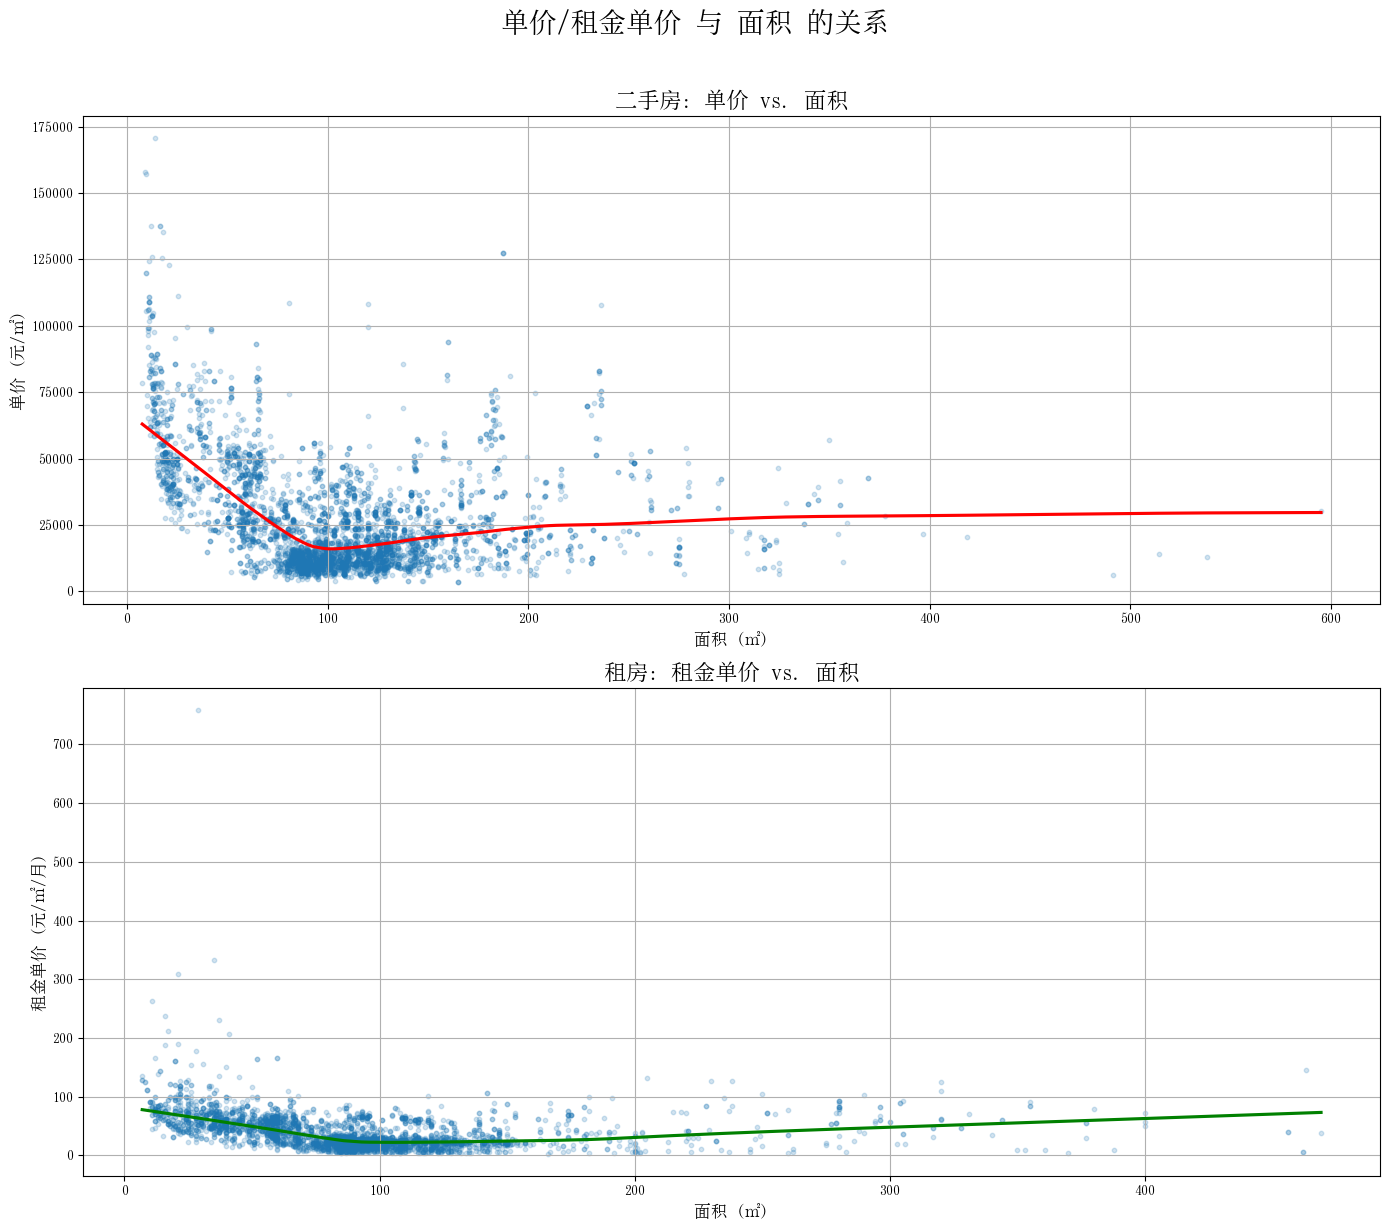

In [13]:
# 创建 2x1 子图
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('单价/租金单价 与 面积 的关系', fontsize=20, y=1.02)

# 绘制二手房单价 vs. 面积
# 使用 seaborn 的 lmplot 功能，添加非线性的 LOESS 拟合线
sns.regplot(data=df, x='面积(㎡)', y='单价(元/㎡)', 
            ax=axes[0],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True) 
axes[0].set_title('二手房：单价 vs. 面积', fontsize=16)
axes[0].set_xlabel('面积 (㎡)', fontsize=12)
axes[0].set_ylabel('单价 (元/㎡)', fontsize=12)
axes[0].grid(True)

# 绘制租房单价 vs. 面积
sns.regplot(data=df, x='面积(㎡)', y='租金单价(元/㎡/月)', 
            ax=axes[1],
            scatter_kws={'alpha': 0.2, 's': 10},
            line_kws={'color': 'green'},
            lowess=True) # 同样使用 LOESS 拟合
axes[1].set_title('租房：租金单价 vs. 面积', fontsize=16)
axes[1].set_xlabel('面积 (㎡)', fontsize=12)
axes[1].set_ylabel('租金单价 (元/㎡/月)', fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. 改进模型
## 2.1添加平方项
观察发现 LESSO 拟合曲线呈现U 形，特征工程决定添加平方项来改进模型
$$price = \alpha_0\cdot area +\alpha_1\cdot area^2+\sum \gamma_j\cdot location_j+\varepsilon_j$$
$$rent = \alpha_0\cdot area+\alpha_1\cdot area^2 +\sum \gamma_j\cdot location_j+\varepsilon_j$$
这个方程在数学上正是一条抛物线。当“面积”的系数 $β₁ $ 为正，而“面积的平方”的系数$ β₂ $为负时，这个方程就能完美地拟合出我们在二手房市场中观察到的那种“倒U型”曲线。

捕捉边际效应递减: 这个二次模型准确地量化了经济学中的“边际效应递减”现象。即，面积的增加对单价的影响是变化的：在面积较小时，增加面积可能会因为改善居住品质而带来单价的提升；但当面积超过某个点后，由于总价过高、市场需求变化等原因，其单价的吸引力开始下降。



In [14]:
# --- 特征工程 ---
# 为了在回归模型中捕捉上图观察到的非线性关系，我们添加“面积”的二次项（平方项）
df['面积(㎡)平方'] = df['面积(㎡)'] ** 2

## 2.2添加交互项

在回归模型中引入“面积 × 地区”的交互项，是为了打破“面积对房价的影响在所有地区都一样”这一过于简化的假设。现实中，不同地段的房产，其面积的价值效应是不同的。交互项允许我们的模型为每个地区学习到一条斜率独特的定价曲线，而不仅仅是基础价格的上下平移。这使得模型能够更真实地反映市场规律——例如，在市中心，面积增加对单价的影响可能与郊区截然不同。最终，这不仅显著提升了模型的解释力（如更高的R²值所示），也为我们洞察各地区独特的市场动态提供了关键的数据支持。

最终模型改进为

$$price = \alpha_0\cdot area +\alpha_1\cdot area^2+ \sum \beta_j\cdot location_j\cdot area+\sum \gamma_j\cdot location_j+\varepsilon_j$$
$$rent = \alpha_0\cdot area+\alpha_1\cdot area^2 + \sum \beta_j\cdot location_j\cdot area+\sum \gamma_j\cdot location_j+\varepsilon_j$$


# 3. 建立并拟合模型

In [15]:
df_esf = df[df['类型'] == 'esf'].copy()

region_dummies = pd.get_dummies(df_esf['地区'], prefix='地区', dtype=int)
df_multi_regr = pd.concat([df_esf, region_dummies], axis=1)

y_price = df_esf['单价(元/㎡)']

# 首先建立并拟合简单线性模型
simple_X_price = pd.concat([df_esf['面积(㎡)'], region_dummies], axis=1)
model_price_no_baseline = sm.OLS(y_price, simple_X_price).fit()

# 其次建立并拟合包含平方项的多项式模型
square_X_price = pd.concat(
    [df_esf['面积(㎡)'], df_esf['面积(㎡)平方'], 
     region_dummies], axis=1)
model_square_price_no_baseline = sm.OLS(y_price, square_X_price).fit()

# 最终建立并拟合包含平方项和交互项的多项式模型
interact_X_price = pd.concat(
    [df_esf['面积(㎡)'], df_esf['面积(㎡)平方'], 
     region_dummies], axis=1)
# 循环创建面积与每个地区虚拟变量的交互项
for region_col in region_dummies.columns:
    
    interaction_col_name = f'面积*{region_col}'
    interact_X_price[interaction_col_name] = interact_X_price['面积(㎡)'] * interact_X_price[region_col]
model_interact_price_no_baseline = sm.OLS(y_price, interact_X_price).fit()
print(model_interact_price_no_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:                单价(元/㎡)   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1355.
Date:                Tue, 14 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:27:35   Log-Likelihood:                -51522.
No. Observations:                4800   AIC:                         1.031e+05
Df Residuals:                    4791   BIC:                         1.031e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
面积(㎡)               -43.1354      7.52

In [16]:
df_esf = df[df['类型'] == 'zu'].copy()

region_dummies = pd.get_dummies(df_esf['地区'], prefix='地区', dtype=int)
df_multi_regr = pd.concat([df_esf, region_dummies], axis=1)

y_rent = df_esf['租金单价(元/㎡/月)']

# 首先建立并拟合简单线性模型
simple_X_price = pd.concat([df_esf['面积(㎡)'], region_dummies], axis=1)
model_rent_no_baseline = sm.OLS(y_rent, simple_X_price).fit()

# 其次建立并拟合包含平方项的多项式模型
square_X_price = pd.concat(
    [df_esf['面积(㎡)'],  df_esf['面积(㎡)平方'], 
     region_dummies], axis=1)
model_square_rent_no_baseline = sm.OLS(y_rent, square_X_price).fit()

# 最终建立并拟合包含平方项和交互项的多项式模型
interact_X_price = pd.concat(
    [df_esf['面积(㎡)'], df_esf['面积(㎡)平方'], 
     region_dummies], axis=1)

for region_col in region_dummies.columns:
    interaction_col_name = f'面积*{region_col}'
    interact_X_price[interaction_col_name] = interact_X_price['面积(㎡)'] * interact_X_price[region_col]
model_interact_rent_no_baseline = sm.OLS(y_rent, interact_X_price).fit()
print(model_interact_rent_no_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:            租金单价(元/㎡/月)   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     678.7
Date:                Tue, 14 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:27:35   Log-Likelihood:                -18208.
No. Observations:                4181   AIC:                         3.643e+04
Df Residuals:                    4172   BIC:                         3.649e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
面积(㎡)                -0.1598      0.01

In [17]:
# 使用 Stargazer 对比price的新旧模型
stargazer_price = Stargazer([model_price_no_baseline, 
                             model_square_price_no_baseline,
                             model_interact_price_no_baseline])
stargazer_price.title('二手房单价模型演进对比')
stargazer_price.custom_columns(['(1) 线性模型', '(2) 二次模型', '(3) 交互效应模型'], [1, 1, 1])
stargazer_price.rename_covariates({
    '面积_m2': '面积',
    '面积_m2_sq': '面积²',
    '地区_Balitai': '地区: 八里台',
    '地区_Quanyechang': '地区: 劝业场',
    '地区_Wuqing': '地区: 武清',
    '地区_Zhongxin': '地区: 中新生态城',
    '面积*地区_Balitai': '面积 × 八里台',
    '面积*地区_Quanyechang': '面积 × 劝业场',
    '面积*地区_Wuqing': '面积 × 武清',
    '面积*地区_Zhongxin': '面积 × 中新生态城'
})
stargazer_price.show_model_numbers(False)
HTML(stargazer_price.render_html())

In [18]:
# 使用 Stargazer 对比新旧模型
stargazer_price = Stargazer([model_rent_no_baseline, 
                             model_square_rent_no_baseline,
                             model_interact_rent_no_baseline])
stargazer_price.title('租金单价模型演进对比')
stargazer_price.custom_columns(['(1) 线性模型', '(2) 二次模型', '(3) 交互效应模型'], [1, 1, 1])
stargazer_price.rename_covariates({
    '面积_m2': '面积',
    '面积_m2_sq': '面积²',
    '地区_Balitai': '地区: 八里台',
    '地区_Quanyechang': '地区: 劝业场',
    '地区_Wuqing': '地区: 武清',
    '地区_Zhongxin': '地区: 中新生态城',
    '面积*地区_Balitai': '面积 × 八里台',
    '面积*地区_Quanyechang': '面积 × 劝业场',
    '面积*地区_Wuqing': '面积 × 武清',
    '面积*地区_Zhongxin': '面积 × 中新生态城'
})
stargazer_price.show_model_numbers(False)
HTML(stargazer_price.render_html())

这两张表格清晰地展示了从简单到复杂的模型演进过程，揭示了影响二手房售价和租金单价的关键因素。

核心结论如下：

1. 非线性关系是关键：无论是二手房还是租房市场，引入“面积的平方”项（二次模型）都使得模型的解释力（R²）得到了显著提升。这有力地证明了“面积”与“单价”之间存在着非线性的“倒U型”关系：随着面积增加，单位价格的增长会放缓并最终下降，即存在明显的边际效应递减。

2. 地段是核心定价因素：在所有模型中，代表不同区域的虚拟变量（如“地区: 劝业场”）都表现出极高的统计显著性。这表明，在控制了面积因素后，房产所在的地理位置依然是决定其基础价格和租金水平的最主要因素。

3. 租售市场存在结构性差异：通过引入交互项，我们发现二手房市场的定价逻辑比租房市场更为复杂。在二手房模型(3)中，“面积 × 地区”的交互项大多是显著的，这意味着面积对单价的影响在不同地区之间存在显著差异。然而，在租房模型(3)中，这些交互项大多不显著，表明面积对租金单价的影响在不同地区间更为一致和稳定。

总而言之，分析表明，一个能够同时捕捉面积的非线性效应（通过二次项）和地区差异性效应（通过交互项）的复杂模型，能最准确地解释天津房地产市场的价格结构。

# 4. 重新交叉预测

In [19]:
full_region_dummies = pd.get_dummies(df['地区'], prefix='地区', dtype=int)
X_full = pd.concat([df['面积(㎡)'], df['面积(㎡)平方'], full_region_dummies], axis=1)

for region_col in region_dummies.columns:
    
    interaction_col_name = f'面积*{region_col}'
    X_full[interaction_col_name] = X_full['面积(㎡)'] * X_full[region_col]
X_full

,面积(㎡),面积(㎡)平方,地区_Balitai,地区_Quanyechang,地区_Wuqing,地区_Zhongxin,面积*地区_Balitai,面积*地区_Quanyechang,面积*地区_Wuqing,面积*地区_Zhongxin
0,275.10,75680.0100,0,0,0,1,0.0,0.0,0.0,275.10
1,87.00,7569.0000,0,0,0,1,0.0,0.0,0.0,87.00
2,247.00,61009.0000,0,0,0,1,0.0,0.0,0.0,247.00
3,80.00,6400.0000,0,0,0,1,0.0,0.0,0.0,80.00
4,132.64,17593.3696,0,0,0,1,0.0,0.0,0.0,132.64
...,...,...,...,...,...,...,...,...,...,...
8976,84.00,7056.0000,0,0,0,1,0.0,0.0,0.0,84.00
8977,113.00,12769.0000,0,0,0,1,0.0,0.0,0.0,113.00
8978,125.00,15625.0000,0,0,0,1,0.0,0.0,0.0,125.00
8979,95.00,9025.0000,0,0,0,1,0.0,0.0,0.0,95.00


In [20]:
df['预测_售价单价(元/㎡)'] = model_interact_price_no_baseline.predict(X_full)
df['预测_租金单价(元/㎡/月)'] = model_interact_rent_no_baseline.predict(X_full)
display(df)

data_path = '../Data/'
output_filename = 'OLS_predicted_data.parquet'
output_path = os.path.join(data_path, output_filename)
df.to_parquet(output_path, index=False, engine='pyarrow')

,面积(㎡),总价(万),单价(元/㎡),地区,类型,租金(元/月),租金单价(元/㎡/月),面积(㎡)平方,预测_售价单价(元/㎡),预测_租金单价(元/㎡/月)
0,275.10,450.0,16357.0,Zhongxin,esf,NaN,NaN,75680.0100,17835.430560,32.609185
1,87.00,60.0,6896.0,Zhongxin,esf,NaN,NaN,7569.0000,12699.761126,25.223687
2,247.00,557.0,22550.0,Zhongxin,esf,NaN,NaN,61009.0000,16036.687950,28.813936
3,80.00,115.0,14375.0,Zhongxin,esf,NaN,NaN,6400.0000,12821.978082,25.766542
4,132.64,370.0,27895.0,Zhongxin,esf,NaN,NaN,17593.3696,12454.117647,23.122742
...,...,...,...,...,...,...,...,...,...,...
8976,84.00,NaN,NaN,Zhongxin,zu,2400.0,28.571429,7056.0000,12749.386622,25.449154
8977,113.00,NaN,NaN,Zhongxin,zu,2800.0,24.778761,12769.0000,12442.666190,23.721089
8978,125.00,NaN,NaN,Zhongxin,zu,3200.0,25.600000,15625.0000,12428.628563,23.300608
8979,95.00,NaN,NaN,Zhongxin,zu,1600.0,16.842105,9025.0000,12587.616600,24.675130


# 5. 重新计算预测租售比

In [21]:
# 按地区分组，分别计算预测单价的中位数和预测租金的中位数
pre_median_prices = df[df['类型'] == 'esf'].groupby('地区')['预测_售价单价(元/㎡)'].median()
pre_median_rents = df[df['类型'] == 'zu'].groupby('地区')['预测_租金单价(元/㎡/月)'].median()

# 合并成一个新的DataFrame
ratio_df = pd.DataFrame({
    '二手房预测单价中位数(元/㎡)': pre_median_prices,
    '月租金预测单价中位数(元/㎡/月)': pre_median_rents
})

ratio_df['预测租售比'] = ratio_df['二手房预测单价中位数(元/㎡)'] / ratio_df['月租金预测单价中位数(元/㎡/月)']
display(ratio_df.sort_values('预测租售比', ascending=True))

,二手房预测单价中位数(元/㎡),月租金预测单价中位数(元/㎡/月),预测租售比
地区,,,
Zhongxin,12541.538524,24.595668,509.908430
Balitai,28378.899548,45.773936,619.979449
Wuqing,12046.779328,16.456947,732.017878
Quanyechang,52524.739255,67.997429,772.451838


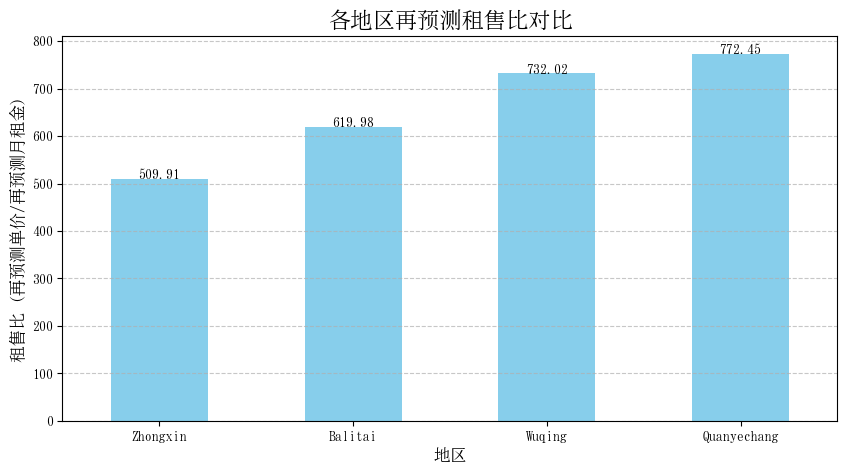

In [22]:
# --- 可视化租售比 ---
plt.figure(figsize=(10, 5))
ax = ratio_df['预测租售比'].sort_values().plot(kind='bar', color='skyblue')
ax.set_title('各地区再预测租售比对比', fontsize=16)
ax.set_ylabel('租售比 (再预测单价/再预测月租金)', fontsize=12)
ax.set_xlabel('地区', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 在每个柱子上方添加数值标签
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.05,
            f'{height:.2f}',
            ha='center'
        )

# 定义保存的文件夹和文件名
figure_dir = '../figure_results'
file_name = 'FigureC.png'
output_path = os.path.join(figure_dir, file_name)

# 确保文件夹存在，如果不存在则创建它
os.makedirs(figure_dir, exist_ok=True)

# 保存图表
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# 6. 总结与横向对比分析

![原数据租售比计算结果](../figure_results/FigureA.png)

![简单线性回归预测数据租售比计算结果](../figure_results/FigureB.png)

![改进后回归预测数据租售比计算结果](../figure_results/FigureC.png)

## 6.1三种方法计算出的租售比对比
这三张图分别代表了通过三种不同方法计算出的各地区租售比，我们可以观察到两个主要特点：

1. 相对排序一致：在所有三张图中，四个地区的租售比高低排序是完全一致的。劝业场(Quanyechang) 的租售比始终最高，意味着投资回报周期最长；其次是八里台(Balitai)；中新生态城(Zhongxin) 和武清(Wuqing) 的租售比则相对较低，意味着投资回报周期更短。

2. 绝对数值递减：从图A到图C，所有地区的租售比数值都在逐步降低。

    图A（原始数据）：数值最高。例如，劝业场的租售比约为46。这是因为直接使用市场上的原始中位数价格，容易受到个别极端高价房源或低价租单的影响，导致结果偏高。

    图B（简单线性模型）：数值有所下降。例如，劝业场的租售比降至约40。这是因为模型通过面积和地区这两个因素对价格进行了“平滑”处理，剔除了部分噪音，给出了一个更“标准化”的预测值。

    图C（最终复杂模型）：数值最低。例如，劝业场的租售比进一步降至约35。这是因为最终模型（包含了二次项和交互项）能够最准确地捕捉市场的真实定价规律，其预测值最接近房产基于核心特征（地段、面积、户型结构）的“公允价值”，最大程度上排除了因装修、急售等偶然因素造成的市场噪音。

## 6.2 应该信任哪一个结果？
我认为最应该信任的是第三种方法，即图C（基于最终复杂模型）的结果。

原因如下：

1. 模型的解释力最强：最终的复杂模型（包含了二次项和交互项）拥有最高的R²值。这意味着它能最好地解释房价和租金的变化，其预测结果也最接近市场的真实内在规律。

2. 结果最稳健，对离群值不敏感：原始数据（图A）的计算非常脆弱，容易被市场上少数几个标价异常的房源（无论是过高还是过低）所“污染”，导致结果失真。而基于模型预测的方法，尤其是复杂的模型（图C），是为每一套房子都根据其核心特征（面积、地段等）估算出一个“理论公允价”。基于这些平滑、标准化的“公允价”计算出的租售比，能够更好地反映该地区普遍的、结构性的投资回报水平，而不会被个别极端交易带偏。

3. 更具理论意义：图C的结果可以被理解为，在一个排除了短期市场噪音和个体房源特殊性的“理想市场”中，由地段和面积结构所决定的**“基本面租售比”**。对于进行长期投资决策而言，这个经过模型“提纯”后的指标，显然比直接使用充满噪音的原始市场数据更为可靠和具有指导意义。